In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pytorch_lightning
import pytorch_lightning as pl
from scipy.stats import pearsonr
from scipy.spatial import distance_matrix, minkowski_distance, distance

# Helper function

In [3]:
def calcWeights(gene_exp, similarityType='pearsonr', ):
  """
  Similarity can be ['pearsonr', 'medianL1', 'rmse', 'cosine'].

  Test the code:
  gene_exp = torch.randn((6, 4))
  [calcWeights(gene_exp, similarityType=i) for i in ['pearsonr', 'medianL1', 'rmse', 'cosine']]
  """
  rows=[]
  for i in range(len(gene_exp)):
    for j in range(len(gene_exp)):
      if similarityType=='pearsonr':
        # Calculate the Pearson correlation coefficient
        rows.append(pearsonr(gene_exp[i], gene_exp[j])[0])
      elif similarityType=='medianL1':
        # Calculate the median L1
        # L1 distance represents the absolute deviation of gene expression between cells.
        # The lower the value means, the higher the similarity, and the better the obtainable imputation effect.
        rows.append(abs(gene_exp[i].median() - gene_exp[j].median()))
      elif similarityType=='rmse':
        # Calculate the RMSE.
        # RMSE represents the square root of the quadratic mean of gene expression differences between cells
        # the smaller the value, the better the effect.
        rows.append(torch.sqrt(torch.mean((gene_exp[i]-gene_exp[j])**2)))
      elif similarityType=='cosine':
        # Calculate the cosine similarity
        # Cosine similarity refers to the product of gene expression between cells.
        # The value range of cosine similarity is [0, 1]; the higher the value, the more similar.
        rows.append(F.cosine_similarity(gene_exp[i].unsqueeze(0), gene_exp[j].unsqueeze(0)))

  weight_adj = F.softmax(torch.tensor(rows).reshape(len(gene_exp), len(gene_exp)), dim=-1)
  return weight_adj.numpy()


def calcADJ(coord, k=0, weights=None, distanceType='euclidean', pruneTag='NA'):
    """
    Calculate spatial Matrix directly use X/Y coordinates.
    If weights are not provided, default weights=1.
    If weights are provided, assign the weight to the spatial distance.
    The weight is from gene expression similarity between cells.
    If the gene expression of cells are similar, the distance between them should be short.
    k is the number of nearest nodes, if k=0 we consider all nodes.

    Test codes:
    ct = torch.randint(0, 40000, (6, 2)).to(torch.float32).long() # 0-40000 is range of whole slide image pixels, 6 is num_cell, 2 is spatial coordinates.
    exp = torch.randn(6,4) # num_cell x num_gene
    calcADJ(ct, k=0, weights=calcWeights(exp).numpy()) # return an adjancency matrix
    """
    spatialMatrix=coord#.cpu().numpy()
    nodes=spatialMatrix.shape[0]
    Adj = torch.zeros((nodes,nodes))
    for i in np.arange(spatialMatrix.shape[0]):
        tmp=spatialMatrix[i,:].reshape(1,-1)
        distMat = distance.cdist(tmp,spatialMatrix, distanceType)
        if weights.all() != None:
          distMat = distMat*weights[i]
        else:
          pass
        k = spatialMatrix.shape[0]-1 if k == 0 else k
        res = distMat.argsort()[:k+1]
        tmpdist = distMat[0,res[0][1:k+1]]
        boundary = np.mean(tmpdist)+np.std(tmpdist) #optional
        for j in np.arange(1,k+1):
            # No prune
            if pruneTag == 'NA':
                Adj[i][res[0][j]]=1.0
            elif pruneTag == 'STD':
                if distMat[0,res[0][j]]<=boundary:
                    Adj[i][res[0][j]]=1.0
            # Prune: only use nearest neighbor as exact grid: 6 in cityblock, 8 in euclidean
            elif pruneTag == 'Grid':
                if distMat[0,res[0][j]]<=2.0:
                    Adj[i][res[0][j]]=1.0
    return Adj

In [4]:
def TCGA_resnet18(MODEL_PATH = '../model/TCGA_resnet18.ckpt',):
    def load_model_weights(model, weights):
        model_dict = model.state_dict()
        weights = {k: v for k, v in weights.items() if k in model_dict}
        if weights == {}:
            print('No weight could be loaded..')
        model_dict.update(weights)
        model.load_state_dict(model_dict)
        return model

    model = torchvision.models.__dict__['resnet18']()
    state = torch.load(MODEL_PATH, map_location='cuda')

    state_dict = state['state_dict']
    for key in list(state_dict.keys()):
        state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

    model = load_model_weights(model, state_dict)

    model.fc = torch.nn.Sequential()
    return model

# Modules

In [5]:
# Feature extractor includes image encoder, Transformer, Graph Neural Network
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """
    def __init__(
        self, model_name='resnet18', pretrained=True, trainable=True
    ):
        super().__init__()
        if model_name=='resnet18':
          self.model = TCGA_resnet18()
          self.model.fc = nn.Identity()

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim=512, num_heads=8):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads=8, dropout=0.2)
        self.norm = nn.LayerNorm(dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, x):
      query, key, value = x, x, x
      attn_output, attn_output_weights = self.attention(query, key, value)
      # Add skip connection and run through normalization
      forward = self.feed_forward(attn_output)
      x = self.norm(attn_output + x)
      out = self.norm(forward + x)
      return out

class GNN(nn.Module):
    def __init__(
        self, feature_dim, embed_dim,
        policy='mean', gcn=False, num_sample=10
    ):
        super().__init__()
        self.gcn = gcn
        self.policy=policy
        self.embed_dim = embed_dim
        self.feat_dim = feature_dim
        self.num_sample = num_sample
        self.weight = nn.Parameter(torch.FloatTensor(
            embed_dim,
            self.feat_dim if self.gcn else 2*self.feat_dim
        ))
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, x, Adj):
        neigh_feats = self.aggregate(x, Adj)
        if not self.gcn:
            combined = torch.cat([x, neigh_feats], dim=1)
        else:
            combined = neigh_feats
        combined = F.relu(self.weight.mm(combined.T)).T
        combined = F.normalize(combined,2,1)
        return combined

    def aggregate(self, x, Adj):
        adj=torch.autograd.Variable(Adj).to(Adj.device)
        if not self.gcn:
            n=len(adj)
            adj = adj-torch.eye(n).to(adj.device)
        if self.policy=='mean':
            num_neigh = adj.sum(1, keepdim=True)
            mask = adj.div(num_neigh)
            to_feats = mask.mm(x)
        elif self.policy=='max':
            indexs = [i.nonzero() for i in adj==1]
            to_feats = []
            for feat in [x[i.squeeze()] for i in indexs]:
                if len(feat.size()) == 1:
                    to_feats.append(feat.view(1, -1))
                else:
                    to_feats.append(torch.max(feat,0)[0].view(1, -1))
            to_feats = torch.cat(to_feats, 0)
        return to_feats


In [6]:
# Self-supervised Learning
import torchvision.transforms as transforms

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=512, lr=1e-3, temperature=0.07, weight_decay=1e-4, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.ImageEncoder = ImageEncoder()

        # Data Augmentation methods
        self.tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.Normalize((0.5,), (0.5,)),])

    def forward(self, x):
        x = self.ImageEncoder(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, patch, mode="train"):
        img1 = self.tf(patch)
        img2 = self.tf(patch)
        imgs = torch.cat([img1, img2], dim=0)

        # Encode all images
        feats = self.convnet(imgs)

        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)

        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        patch, exp, label = batch
        patch = patch.to(torch.float32)
        return self.info_nce_loss(patch, mode="train")

    def validation_step(self, batch, batch_idx):
        patch, exp, label = batch
        patch = patch.to(torch.float32)
        self.info_nce_loss(patch, mode="val")


In [7]:
# Multi-task Learning for downstream tasks

# One layer neural network, predict highly variable genes or marker genes.
class GeneExpRegression(nn.Module):
    def __init__(
        self,
        embedding_dim=512,
        num_genes=280,
        dropout=0.2,
    ):
        super().__init__()
        self.reg = nn.Linear(embedding_dim, num_genes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.reg(x))
        return x

# One layer neural network, predict cell types at patch level.
class CellTypeClassifier(nn.Module):
    def __init__(
        self,
        embedding_dim=512,
        num_class=8,
        dropout=0.2,
    ):
        super().__init__()
        self.gelu = nn.GELU()
        self.fc = nn.Linear(embedding_dim, num_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = nn.Softmax(dim=1)(x)
        return x

# One layer neural network, predict cell types at tissue level.
class TissueTypeClassifier(nn.Module):
    def __init__(
        self,
        embedding_dim=512,
        num_class=2,
        dropout=0.2,
    ):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, num_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = nn.Softmax(dim=1)(x)
        return x

# Attention aggregation
class AttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, input_vectors):
        # Compute attention scores
        attention_scores = self.linear(input_vectors).squeeze(dim=-1)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention weights to input vectors
        attention_pooled = torch.sum(attention_weights.unsqueeze(-1) * input_vectors, dim=1)
        return attention_pooled

# Patch aggregation by average, max, sum, attention
class PatchAggregation(nn.Module):
    def __init__(self, aggregation_method="Attention_pool", dim=512, ):
        super().__init__()
        self.aggregation_method = aggregation_method
        if aggregation_method == "Attention_pool":
          self.agg =  AttentionPooling(dim)

    def forward(self, x):
      if self.aggregation_method == "Attention_pool":
        x = self.agg(x)
      elif self.aggregation_method == "Average_pool":
        x = x.mean(dim=1)
      elif self.aggregation_method == "Max_pool":
        x, index = x.max(dim=1)
      elif self.aggregation_method == "Sum_pool":
        x, index = x.sum(dim=1)
      return x


# Model

In [8]:
class Regclass(nn.Module):
    def __init__(self, transformer=False, gnn=False, TissueCls=False, ensemble_exp=False,
                 ensemble_cell_type=False,
                 dim=512, n_pos=256, transformer_layers=4, gnn_layers=3,
                 aug=True, num_genes=280,
                 ):
        super().__init__()
        """
        Model input shape:
        patches = torch.randn(10,3,224,224)
        ct = torch.randint(0, 40000, (1, 10, 2)).to(torch.float32).long()
        adj = torch.randint(0, 100, (1, 10, 10)).to(torch.float32).squeeze(0)

        Model output shape:
        torch.Size([10, 280])
        torch.Size([10, 8])
        torch.Size([1, 2])
        gene_exp, cell_type_prob, tissue_type_prob
        """
        self.TissueCls = TissueCls
        self.transformer = transformer
        self.gnn = gnn
        self.gnn_layers = gnn_layers
        self.aug = aug
        self.ensemble_exp=ensemble_exp
        self.ensemble_cell_type=ensemble_cell_type

        # Data augmentation enhance robustness
        if self.aug:
          self.tf = transforms.Compose([
          transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=9),
                                  transforms.RandomResizedCrop(size=96),
                                  transforms.RandomHorizontalFlip(),
                                  ], p=0.5),

          ])
        self.image_encoder = SimCLR().ImageEncoder
        if self.transformer:
          self.x_embed = nn.Embedding(n_pos, dim)
          self.y_embed = nn.Embedding(n_pos, dim)
          self.Transformer = nn.Sequential(*[TransformerBlock() for i in range(transformer_layers)])

        if self.gnn:
          self.GNN = nn.ModuleList([GNN(dim, dim) for i in range(gnn_layers)])
          # jumping knowledge to alleviate over-smoothing issues
          self.jknet=nn.Sequential(nn.LSTM(dim,dim,2),)

        if self.ensemble_exp:
          self.GeneExpRegression = [GeneExpRegression(num_genes=1) for i in range(num_genes)]
        else:
          self.GeneExpRegression = GeneExpRegression(num_genes=num_genes)

        if self.ensemble_cell_type:
          self.CellTypeClassifier = [CellTypeClassifier() for i in range(5)]
        else:
          self.CellTypeClassifier = CellTypeClassifier()

        if self.TissueCls:
          self.PatchAggregation = PatchAggregation()
          self.TissueTypeClassifier = TissueTypeClassifier()

    def forward(self, patches, ct, adj):
      patch_ft = self.feature_extraction(patches, ct, adj) # Feature extraction
      gene_exp = self.gene_expression_prediction(patch_ft) # Gene expression prediction
      cell_type_prob, cell_type = self.cell_type_prediction(patch_ft) # Cell type prediction
      if self.TissueCls:
        tissue_type_prob, tissue_type = self.tissue_type_prediction(patch_ft) # Tissue type prediction
        return gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type
      else:
        return gene_exp, cell_type_prob, cell_type, _, _

    def feature_extraction(self, patches, ct, adj):
      # Feature extraction including data augmentation on image patches, then extract image features using CNN, transformer, gnn seqentially
      patch_ft = self.image_encoder(transforms.Resize(224)(patches))

      if self.transformer:
        # Position encoding
        centers_x = self.x_embed(ct[:,:,0])
        centers_y = self.y_embed(ct[:,:,1])
        cts = centers_x + centers_y
        test = patch_ft+cts.squeeze(0)
        patch_ft = self.Transformer(patch_ft+cts.squeeze(0))

      if self.gnn:
        jk = [layer(patch_ft,adj).unsqueeze(0) for layer in self.GNN]
        patch_ft = self.jknet(torch.cat(jk,0))[0].mean(0)
      return patch_ft

    def gene_expression_prediction(self, patch_ft):
      # Predict gene expression
      if self.ensemble_exp:
        """
        The deep ensemble or multi-task model is built based upon the baseline and patch-based model.
        Instead of using one fc layer for all genes prediction, we use separate fc layers for each gene prediction.
        Each of the gene expression prediction can be considered as separate task which have something in common in
        their parameters.
        """
        pred_genes = [fc(patch_ft) for fc in self.GeneExpRegression]
        gene_exp = torch.cat(pred_genes, dim=1)
      else:
        pred_genes = [self.GeneExpRegression(patch_ft) for _ in range(5)]
        gene_exp = torch.stack(pred_genes, dim=0).mean(dim=0)
      return gene_exp

    def cell_type_prediction(self, patch_ft):
      # Predict cell type
      if self.ensemble_cell_type:
        cell_prob = [fc(patch_ft).unsqueeze(0) for fc in self.CellTypeClassifier]
        cell_type_prob = torch.cat(cell_prob, dim=0).mean(dim=0)
      else:
        cell_type_prob = self.CellTypeClassifier(patch_ft)
      _, cell_type = cell_type_prob.topk(1, dim=1)
      return cell_type_prob, cell_type

    def tissue_type_prediction(self, patch_ft):
      # Predict tissuue type
      tissue_ft = self.PatchAggregation(patch_ft.unsqueeze(0))
      tissue_type_prob = self.TissueTypeClassifier(tissue_ft)
      _, tissue_type = tissue_type_prob.topk(1, dim=1)
      return tissue_type_prob, tissue_type

    def return_ensemble_regression(self, patches, ct, adj):
      # Return the results of ensemble model for visualization of uncertainty band
      patch_ft = self.image_encoder(transforms.Resize(224)(patches))
      if self.transformer:
        # Position encoding
        centers_x = self.x_embed(ct[:,:,0])
        centers_y = self.y_embed(ct[:,:,1])
        cts = centers_x + centers_y
        test = patch_ft+cts.squeeze(0)
        patch_ft = self.Transformer(patch_ft+cts.squeeze(0))

      if self.gnn:
        jk = [layer(patch_ft,adj).unsqueeze(0) for layer in self.GNN]
        patch_ft = self.jknet(torch.cat(jk,0))[0].mean(0)

      # Predict gene expression
      gene_exp = [self.GeneExpRegression(patch_ft) for _ in range(5)]
      return gene_exp

    def training_step(self, batch, batch_idx):
        patches, ct, adj, exp, cell_lbl, tissue_lbl = batch
        if self.aug:
          patches = self.tf(patches.to(torch.float32).squeeze(0))
        else:
          patches = patches.to(torch.float32).squeeze(0)
        adj = adj.squeeze(0)

        # Model prediction
        gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type = self(patches, ct, adj)

        # Cell types classification loss
        cell_cls_loss = F.cross_entropy(cell_type_prob, cell_lbl.view(-1).long())
        self.log('Train_CellCls_loss', cell_cls_loss, on_epoch=True, prog_bar=True, logger=True)
        cell_acc = (cell_type == cell_lbl.view(-1)).float().mean()
        self.log('Train_CellCls_accuracy', cell_acc, on_epoch=True, prog_bar=True, logger=True)

        # Gene expression regression loss
        exp_mse = F.mse_loss(gene_exp, exp)
        self.log('Train_ExpReg_loss', exp_mse, on_epoch=True, prog_bar=True, logger=True)
        MeanPCC = torch.Tensor([pearsonr(gene_exp[gene],exp[gene])[0] for gene in range(self.num_genes)]).mean()
        self.log('Train_MeanPCC', MeanPCC, on_epoch=True, prog_bar=True, logger=True)

        # Tissue types classification loss
        if self.TissueCls:
          tissue_cls_loss = F.cross_entropy(tissue_type_prob, tissue_lbl.view(-1).long())
          self.log('Train_tissue_cls_loss', tissue_cls_loss, on_epoch=True, prog_bar=True, logger=True)
          tissue_acc = (tissue_type == tissue_lbl.view(-1)).float().mean()
          loss = cell_cls_loss + tissue_cls_loss + exp_mse
        else:
          loss = cell_cls_loss + exp_mse
        return loss

    def validation_step(self, batch, batch_idx):
        patches, ct, adj, exp, cell_lbl, tissue_lbl = batch
        if self.aug:
          patches = self.tf(patches.to(torch.float32).squeeze(0))
        else:
          patches = patches.to(torch.float32).squeeze(0)
        adj = adj.squeeze(0)

        # Model prediction
        gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type = self(patches, ct, adj)

        # Cell types classification loss
        cell_cls_loss = F.cross_entropy(cell_type_prob, cell_lbl.view(-1).long())
        self.log('Valid_CellCls_loss', cell_cls_loss, on_epoch=True, prog_bar=True, logger=True)
        cell_acc = (cell_type == cell_lbl.view(-1)).float().mean()
        self.log('Valid_CellCls_accuracy', cell_acc, on_epoch=True, prog_bar=True, logger=True)

        # Gene expression regression loss
        exp_mse = F.mse_loss(gene_exp, exp)
        self.log('Valid_ExpReg_loss', exp_mse, on_epoch=True, prog_bar=True, logger=True)
        MeanPCC = torch.Tensor([pearsonr(gene_exp[gene],exp[gene])[0] for gene in range(self.num_genes)]).mean()
        self.log('Valid_MeanPCC', MeanPCC, on_epoch=True, prog_bar=True, logger=True)

        # Tissue types classification loss
        if self.TissueCls:
          tissue_cls_loss = F.cross_entropy(tissue_type_prob, tissue_lbl.view(-1).long())
          self.log('Valid_TissueCls_loss', tissue_cls_loss, on_epoch=True, prog_bar=True, logger=True)
          tissue_acc = (tissue_type == tissue_lbl.view(-1)).float().mean()
          self.log('Valid_TissueCls_accuracy', tissue_acc, on_epoch=True, prog_bar=True, logger=True)

          loss = cell_cls_loss + tissue_cls_loss + exp_mse
        else:
          loss = cell_cls_loss + exp_mse
        return loss

    def test_step(self, batch, batch_idx):
        patches, ct, adj, exp, cell_lbl, tissue_lbl = batch
        if self.aug:
          patches = self.tf(patches.to(torch.float32).squeeze(0))
        else:
          patches = patches.to(torch.float32).squeeze(0)
        adj = adj.squeeze(0)

        # Model prediction
        gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type = self(patches, ct, adj)

        # Cell types classification loss
        cell_acc = (cell_type == cell_lbl.view(-1)).float().mean()
        self.log('Test_CellCls_accuracy', cell_acc, on_epoch=True, prog_bar=True, logger=True)

        # Gene expression regression loss
        MeanPCC = torch.Tensor([pearsonr(gene_exp[gene],exp[gene])[0] for gene in range(self.num_genes)]).mean()
        self.log('Test_MeanPCC', MeanPCC, on_epoch=True, prog_bar=True, logger=True)

        # Tissue types classification loss
        if self.TissueCls:
          tissue_acc = (tissue_type == tissue_lbl.view(-1)).float().mean()
          self.log('Test_CellCls_accuracy', tissue_acc, on_epoch=True, prog_bar=True, logger=True)


    def predict_step(self, batch, batch_idx):
        patches, ct, adj, exp, cell_lbl, tissue_lbl = batch
        patches = transforms.Resize(224)(patches.to(torch.float32).squeeze(0))
        adj = adj.squeeze(0)

        # Model prediction
        gene_exp, cell_type_prob, tissue_type_prob = self(patches, ct, adj)
        _, cell_pred = cell_type_prob.topk(1, dim=1)
        if self.TissueCls:
          _, tissue_pred = tissue_type_prob.topk(1, dim=1)
          return gene_exp, cell_type_prob, cell_pred, tissue_type_prob, tissue_pred
        else:
          return gene_exp, cell_type_prob, cell_pred


# Test model

In [9]:
# Example usage
input_dim = 16

patches = torch.randn(10,3,224,224)
ct = torch.randint(0, 40000, (1,10, 2)).to(torch.float32).long()
adj = torch.randint(0, 100, (1, 10, 10)).to(torch.float32).squeeze(0)

gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type = Regclass(transformer=True, gnn=True, TissueCls=True, ensemble_exp=True,
                 ensemble_cell_type=True,
                 dim=512, n_pos=40000, transformer_layers=4, gnn_layers=3,
                 aug=True, num_genes=280,)(patches, ct, adj)

for i in [gene_exp, cell_type_prob, cell_type, tissue_type_prob, tissue_type]:
  print(i)

/scratch/imb/uqyjia11/.conda/envs/pt3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[-0.0183, -0.0308,  0.0463,  ...,  0.0428, -0.0291, -0.0628],
        [-0.0182, -0.0000,  0.0458,  ...,  0.0000, -0.0301, -0.0621],
        [-0.0000, -0.0300,  0.0000,  ...,  0.0435, -0.0297, -0.0000],
        ...,
        [-0.0191, -0.0315,  0.0462,  ...,  0.0434, -0.0291, -0.0633],
        [-0.0201, -0.0295,  0.0000,  ...,  0.0000, -0.0299, -0.0629],
        [-0.0188, -0.0299,  0.0000,  ...,  0.0423, -0.0000, -0.0634]],
       grad_fn=<CatBackward0>)
tensor([[0.1250, 0.1248, 0.1255, 0.1221, 0.1242, 0.1254, 0.1253, 0.1276],
        [0.1246, 0.1246, 0.1251, 0.1222, 0.1251, 0.1249, 0.1257, 0.1278],
        [0.1245, 0.1251, 0.1251, 0.1219, 0.1247, 0.1253, 0.1265, 0.1270],
        [0.1247, 0.1256, 0.1243, 0.1234, 0.1245, 0.1266, 0.1241, 0.1268],
        [0.1248, 0.1254, 0.1261, 0.1208, 0.1247, 0.1269, 0.1244, 0.1269],
        [0.1233, 0.1257, 0.1255, 0.1214, 0.1262, 0.1258, 0.1255, 0.1266],
        [0.1236, 0.1258, 0.1249, 0.1230, 0.1248, 0.1262, 0.1253, 0.1264],
        [0.1235, 

# Visualization

## Uncertainty band for regression task

(1) Plot the mean and variance of gene expression values for one gene.
 https://github.com/BiomedicalMachineLearning/STimage/blob/master/Figure_scripts/FigureS3/TCIA.ipynb

(2) Plot the observations, mean prediction and uncertainty band for each gene or cell.

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_regression_uncertainty_band(model_predictions, ground_truth, plot_gene=True,
                                     gene_list=None, gene_name="CD4",):
    """
    Assuming ground truth and predictions from each model have shape (10, 280).
    if plot_gene=False, plot for one gene. else plot for one cell.

    Test_codes:
    model_predictions = [torch.randn((10, 280)) for _ in range(10)]
    ground_truth = torch.randn((10, 280))
    gene_list = ['cd4', 'cd5','cd18']
    gene_name = 'cd4'
    plot_regression_uncertainty_band(model_predictions, ground_truth, plot_gene=False, gene_list, gene_name)
    """

    # Stack predictions along a new dimension (axis 0)
    all_predictions = torch.stack(model_predictions, dim=0)

    # Calculate mean prediction
    mean_prediction = torch.mean(all_predictions, dim=0)

    # Calculate variance and standard deviation
    variance = torch.var(all_predictions, dim=0)
    std_deviation = torch.sqrt(variance)

    # Set the uncertainty level (e.g., 1 standard deviation)
    uncertainty_band = 1.0

    # Calculate lower and upper bounds of the uncertainty band
    lower_bound = mean_prediction - uncertainty_band * std_deviation
    upper_bound = mean_prediction + uncertainty_band * std_deviation

    # Figure size
    plt.figure(figsize=(10, 5))

    # Set color
    sns.set_palette("Set2")

    # Visualize the results
    if plot_gene:
      idx = gene_list.index(gene_name)

      indices = range(ground_truth.shape[1])  # Assuming 280 genes
      # Plot the ground truth
      plt.plot(indices, ground_truth[idx].detach().numpy(), 'ko', markersize=4, label='Observations')

      # Plot the mean prediction
      plt.plot(indices, mean_prediction[idx].detach().numpy(), label='Mean Prediction', color="red")

      # Plot the uncertainty band
      plt.fill_between(indices, lower_bound[idx].detach().numpy(), upper_bound[0].detach().numpy(), color="lightgrey", label='Uncertainty Band')

      # Customize the plot
      plt.title('Ensemble Prediction with Uncertainty Band')
      plt.xlabel('Gene Index')
      plt.ylabel('Expression Values')
      plt.legend()
      plt.show()
    else:
      indices = range(ground_truth.shape[0])  # Assuming 280 genes
      # Plot the ground truth
      plt.plot(indices, ground_truth[:,0].detach().numpy(), 'ko', markersize=4, label='Observations')

      # Plot the mean prediction
      plt.plot(indices, mean_prediction[:,0].detach().numpy(), label='Mean Prediction', color="red")

      # Plot the uncertainty band
      plt.fill_between(indices, lower_bound[:,0].detach().numpy(), upper_bound[:,0].detach().numpy(), color="lightgrey", label='Uncertainty Band')


      # Customize the plot
      plt.title('Ensemble Prediction with Uncertainty Band')
      plt.xlabel('Cell Index')
      plt.ylabel('Expression Values')
      plt.legend()
      plt.show()


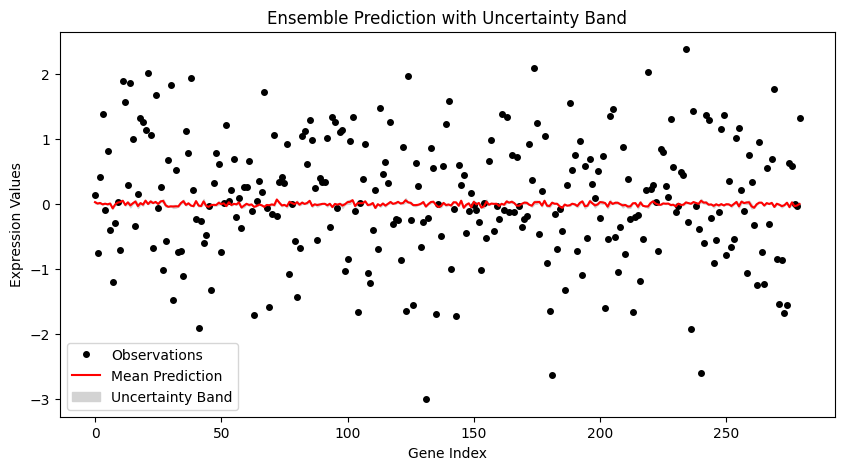

In [11]:
model_predictions = Regclass(transformer=True, gnn=True, TissueCls=True, aug=True, ensemble_exp=False,
                 dim=512, n_pos=50000, transformer_layers=4, gnn_layers=3,).return_ensemble_regression(patches, ct, adj)
# model_predictions = [torch.randn((10, 280)) for _ in range(10)]
ground_truth = torch.randn((10, 280))
gene_list = ['cd4', 'cd5','cd18']
gene_name = 'cd4'
plot_regression_uncertainty_band(model_predictions, ground_truth, plot_gene=True, gene_list=gene_list, gene_name=gene_name)

## Conformal prediction for classification task

In [12]:
def quantile(scores, alpha=0.1):
  # compute conformal quantile
  n = len(scores)
  q_val = np.ceil((1 - alpha) * (n + 1)) / n
  return np.quantile(scores, q_val, method="higher")

def mean_set_size(sets):
  # mean prediction set size
  return np.mean(np.sum(sets, axis=1), axis=0)

def emp_coverage(sets, target):
  # empirical coverage
  return sets[np.arange(len(sets)), target].mean()

### Naive softmax

In [13]:
# Calculate conformal quantile on calibration data (training data)
gt_lbl = torch.randint(0,8,(1,10)) # ground truth label
cal_smx = cell_type_prob # softmax results for training data

scores = 1 - cal_smx[np.arange(cal_smx.shape[0]), gt_lbl.numpy()].view(-1).detach().numpy()
q = quantile(scores)
print(f"Softmax cut-off level: {1-q}")

Softmax cut-off level: 0.12356042861938477


In [14]:
# Evaluate prediction sets on test data
test_smx = cell_type_prob.detach().numpy() # softmax results for test data

pred_sets = test_smx >= (1-q)

print(f"Mean set size: {mean_set_size(pred_sets)}")
print(f"Empirical coverage: {emp_coverage(pred_sets, gt_lbl.numpy())}")

Mean set size: 6.7
Empirical coverage: 0.9


### APS

In [15]:
# Calculate conformal quantile on calibration data
cal_smx = cell_type_prob.detach().numpy() # softmax results for training data
gt_lbl = torch.randint(0,8,(1,10)) # ground truth label

cal_pi = cal_smx.argsort(axis=1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(cal_smx.shape[0]), gt_lbl.numpy()].reshape(gt_lbl.shape[1])
q = quantile(scores)
print(f"Softmax cut-off level: {q}")

Softmax cut-off level: 0.8778590559959412


In [16]:
# Evaluate prediction sets on test data
test_smx = cell_type_prob.detach().numpy() # softmax results for test data
y_test = torch.randint(0,8,(1,10)) # ground truth label

test_pi = test_smx.argsort(axis=1)[:, ::-1]
test_srt = np.take_along_axis(test_smx, test_pi, axis=1).cumsum(axis=1)
pred_sets = np.take_along_axis(test_srt <= q, test_pi.argsort(axis=1), axis=1)
print(f"Mean set size: {mean_set_size(pred_sets)}")
print(f"Empirical coverage: {emp_coverage(pred_sets, y_test.numpy())}")

Mean set size: 6.4
Empirical coverage: 0.8
